In [32]:
import importlib
import os
import subprocess
import pandas as pd
import platform
import pathlib
import requests
from io import StringIO
import numpy as np
from annotations import *
from extract_video_features import *
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.metrics import f1_score
import extract_video_features
importlib.reload(extract_video_features)
from extract_video_features import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from imblearn.ensemble import BalancedRandomForestClassifier

In [33]:
filename_annotations = 'https://docs.google.com/spreadsheets/d/1Rqu1sJiD-ogc4a6R491JTiaYacptOTqh6DKqhwTa8NA/gviz/tq?tqx=out:csv&sheet=Template'

features_folder = 'C:/Users/vince/Documents/TELECOM/Fil_Rouge/OpenFace/OpenFace_2.2.0/processed/'
video_folder = 'C:/Users/vince/Documents/TELECOM/Fil_Rouge/VideoAFPA'

In [3]:
video_names = [x.replace('.mp4','') for x in os.listdir(video_folder)]
video_names.remove('WIN_20210329_14_13_45_Pro')
video_names.remove('WIN_20210403_18_49_15_Pro')
video_names.remove('WIN_20210402_14_27_50_Pro')
#video_names.remove('WIN_20210407_15_02_22_Pro')

video_names = [sub.replace('.txt', '') for sub in video_names]

In [4]:
features_to_keep = [
'frame','face_id','timestamp','confidence','success',

'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r',
'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c',

'gaze_0_x','gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z',
'gaze_angle_x', 'gaze_angle_y', 
'pose_Tx', 'pose_Ty', 'pose_Tz','pose_Rx', 'pose_Ry', 'pose_Rz',

'type_candidat','sexe','video_name','stress_global','stress','diapo'
]

In [5]:
list_df = []
aggreg = 'max'
for v_name in tqdm(video_names):
    df_annoted = get_df_video_with_annotations(features_folder, v_name, filename_annotations,aggreg)[features_to_keep]
    list_df.append(df_annoted)

100%|██████████| 28/28 [01:06<00:00,  2.38s/it]


In [6]:
to_drop = ['frame','face_id','timestamp','confidence','success']

list_df_with_dist=[]
for i in tqdm(list_df):
    l=add_dist_features(i)
    l.drop(to_drop,axis='columns', inplace=True)
    list_df_with_dist.append(l)

groupby_features = ['video_name','stress_global','stress','diapo','type_candidat','sexe','dist_head', 'dist_gaze_0', 'dist_gaze_1', 'dist_pose_x','dist_pose_y', 'dist_pose_z' ]

df = pd.concat(list_df_with_dist)
#df = df.groupby(groupby_features).mean().reset_index()
df = df.groupby(groupby_features).agg({'mean','std'}).reset_index()
df.columns = df.columns.map('_'.join).str.strip('_')
df

100%|██████████| 28/28 [01:53<00:00,  4.04s/it]


,video_name,stress_global,stress,diapo,type_candidat,sexe,dist_head,dist_gaze_0,dist_gaze_1,dist_pose_x,...,AU23_c_std,AU23_c_mean,AU25_c_std,AU25_c_mean,AU26_c_std,AU26_c_mean,AU28_c_std,AU28_c_mean,AU45_c_std,AU45_c_mean
0,Test_pour_AFPA,1.0,0.0,9,Stagiaire,H,44.467469,0.621534,0.705981,0.145665,...,0.479567,0.358249,0.499060,0.531987,0.356966,0.850168,0.164846,0.027946,0.493287,0.417845
1,Test_pour_AFPA,1.0,0.0,10,Stagiaire,H,41.696521,0.562944,0.645913,0.136381,...,0.455041,0.292537,0.500118,0.502488,0.493503,0.581095,0.096789,0.009453,0.468259,0.324378
2,Test_pour_AFPA,1.0,0.0,11,Stagiaire,H,46.746221,0.683707,0.727095,0.180677,...,0.477917,0.352778,0.492431,0.412847,0.456184,0.295139,0.064426,0.004167,0.482926,0.370139
3,Test_pour_AFPA,1.0,0.0,17,Stagiaire,H,67.720741,0.684854,0.738246,0.282390,...,0.497722,0.550575,0.482488,0.632184,0.470856,0.668966,0.075635,0.005747,0.427469,0.240230
4,Test_pour_AFPA,1.0,1.0,1,Stagiaire,H,35.959408,0.525630,0.567888,0.120576,...,0.497659,0.451176,0.328402,0.122941,0.439532,0.261569,0.077735,0.006078,0.409151,0.212549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,WIN_20210417_14_53_12_Pro,0.0,0.0,10,Stagiaire,F,45.825063,0.949746,1.151113,0.175213,...,0.249218,0.933499,0.352601,0.145409,0.339124,0.132506,0.000000,0.000000,0.366051,0.159305
220,WIN_20210417_14_53_12_Pro,0.0,0.0,11,Stagiaire,F,44.743198,0.942931,1.105028,0.179020,...,0.255098,0.930055,0.338091,0.131579,0.263101,0.074792,0.061609,0.003809,0.374489,0.168629
221,WIN_20210417_14_53_12_Pro,0.0,1.0,12,Stagiaire,F,53.671493,0.925096,1.154474,0.151404,...,0.437607,0.741949,0.387306,0.183732,0.310373,0.107969,0.032115,0.001032,0.330402,0.124690
222,WIN_20210417_14_53_12_Pro,0.0,1.0,17,Stagiaire,F,57.926143,0.837893,1.217370,0.200221,...,0.075549,0.994266,0.442147,0.266055,0.470995,0.331422,0.216643,0.049312,0.422857,0.232798


In [15]:
'''
from sklearn.model_selection import cross_val_score
kfold = 4 #stratified
model = RandomForestClassifier(random_state = 42)

a = cross_val_score(estimator=model, scoring='f1_weighted', X=x, y=y, cv=kfold)
print('F1 score = ', np.mean(a))

a = cross_val_score(estimator=model, scoring='accuracy', X=x, y=y, cv=kfold)
print('Accuracy = ', np.mean(a))
'''

dist = [s for s in x.columns.tolist() if "dist" in s]

AUR = [s for s in x.columns.tolist() if "_r_" in s]

AUC = [s for s in x.columns.tolist() if "_c_" in s]

## Ordinal Classification

In [16]:
x = df.drop(['video_name','stress_global','stress','diapo','type_candidat'],axis=1)
#Replace string values
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)
y = df[['stress']]

#Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [17]:
x = x.drop(AUC,axis=1)

In [18]:
import ordinal_classification as o_c
importlib.reload(o_c)

model1 = RandomForestClassifier(random_state = 42)
model2 = RandomForestClassifier(random_state = 42)
model3 = RandomForestClassifier(random_state = 42)
list_models = [model1, model2, model3]
y_preds = o_c.ordinal_classification(list_models, x_train, y_train, x_test)
y_preds

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0], dtype=int64)

In [19]:
cm = confusion_matrix(y_test, y_preds)
print("F1 score = ", f1_score(y_test, y_preds, average='weighted'))

F1 score =  0.5970250169033131


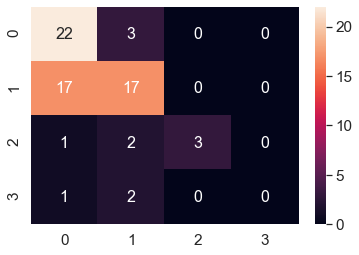

In [20]:
df_cm = pd.DataFrame(cm, range(4), range(4))
#plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

## Classic cross val prediction

In [29]:
x = df.drop(['video_name','stress_global','stress','diapo','type_candidat'],axis=1)
#Replace string values
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)
y = df[['stress']]
y = y.values.squeeze()

#Split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [30]:
x = x.drop(AUC,axis=1)

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import ordinal_classification as o_c
importlib.reload(o_c)

model = RandomForestClassifier(random_state = 42)

#For ordinal classif
model1 = RandomForestClassifier(random_state = 42)
model2 = RandomForestClassifier(random_state = 42)
model3 = RandomForestClassifier(random_state = 42)
list_models = [model1, model2, model3]
#

conf_matrix_list_of_arrays = []
F1_list = []
Acc_list = []

n_splits=4
skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

for train_index, test_index in skf.split(x, y):
   #Split
   x_train, x_test = x.iloc[train_index], x.iloc[test_index]
   y_train, y_test = y[train_index], y[test_index]
   #Fit predict
   model.fit(x_train, y_train)
   #y_pred = model.predict(x_test)
   
   #y_pred = np.ones(56)
   #Ordinal classification
   y_pred = o_c.ordinal_classification(list_models, x_train, y_train, x_test)
   
   #Metrics
   f1 = f1_score(y_test, y_pred, average='weighted')
   acc = accuracy_score(y_test, y_pred)
   conf_matrix = confusion_matrix(y_test, y_pred)

   F1_list.append(f1)
   Acc_list.append(acc)
   conf_matrix_list_of_arrays.append(conf_matrix)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)
sum_of_conf_matrix_arrays = np.sum(conf_matrix_list_of_arrays, axis=0)
print('Mean F1 score = ',np.mean(F1_list))
print('Mean Acc score = ',np.mean(Acc_list))

Mean F1 score =  0.5572826682905412
Mean Acc score =  0.5803571428571428


### Confusion matrix of cross-val

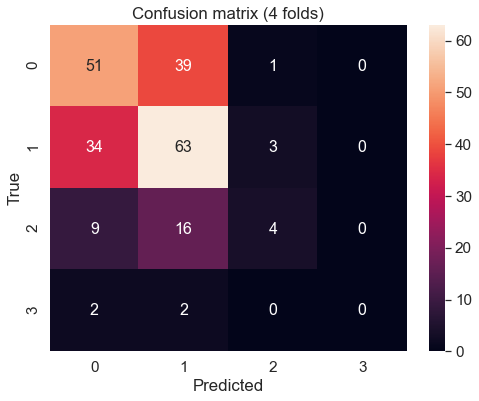

In [28]:
df_cm = pd.DataFrame(sum_of_conf_matrix_arrays, range(4), range(4))
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.title('Confusion matrix ('+str(n_splits)+' folds)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

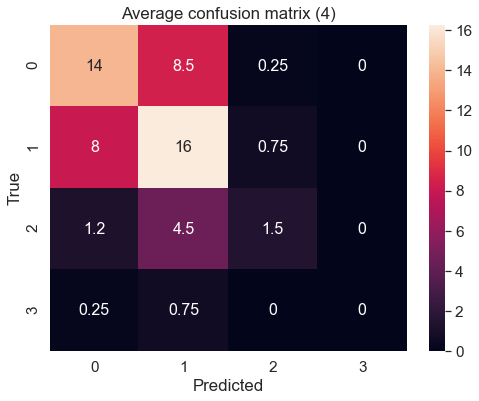

In [313]:
df_cm = pd.DataFrame(sum_of_conf_matrix_arrays, range(4), range(4))
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.title('Average confusion matrix ('+str(n_splits)+')')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [336]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:-20]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


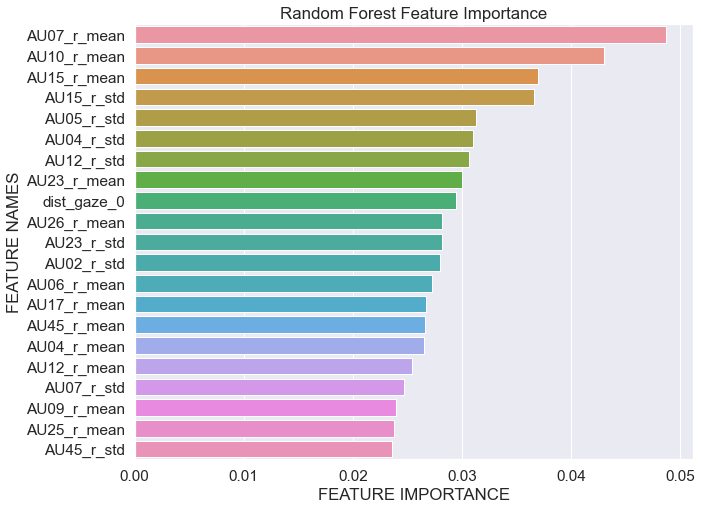

In [337]:
plot_feature_importance(model.feature_importances_,x_train.columns,'Random Forest') 

In [50]:
'''
from sklearn.model_selection import cross_val_score
kfold = 4 #stratified
model = RandomForestClassifier(random_state = 42)

a = cross_val_score(estimator=model, scoring='f1_weighted', X=x, y=y, cv=kfold)
print('F1 score = ', np.mean(a))

a = cross_val_score(estimator=model, scoring='accuracy', X=x, y=y, cv=kfold)
print('Accuracy = ', np.mean(a))
'''

dist = [s for s in x.columns.tolist() if "dist" in s]

AUR = [s for s in x.columns.tolist() if "_r_" in s]

AUC = [s for s in x.columns.tolist() if "_c_" in s]

,5,6,7,8,9,10,11,12,13,14,15,16,17,18
3,0,0,0,0,1,1,0,0,0,1,0,1,1,0
4,0,0,0,0,1,0,1,0,0,0,1,0,0,0
5,1,0,1,1,1,1,1,0,1,1,1,1,1,1
6,0,0,1,1,0,1,1,0,1,1,0,0,0,0
7,0,0,1,1,0,1,1,0,1,0,0,0,0,1
8,0,0,1,0,0,1,1,0,0,0,0,0,0,0
11,0,0,0,1,1,0,0,1,0,1,1,0,0,1
12,0,0,1,1,0,0,1,1,0,1,1,0,0,0
13,0,0,0,0,1,0,1,0,0,0,0,0,0,0
14,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [78]:
df_annotations = pd.read_csv(filename_annotations,  header=None).drop([0, 1, 2])
df_annotations = df_annotations.drop([0,1,2,3,4,19,20,21,22,23,24,25],axis=1)
df_annotations = df_annotations.dropna().astype(int)
df_annotations

In [79]:
def CronbachAlpha(itemscores):
    # cols are items, rows are observations
    k = df_annotations.shape[1] #Number of items (cols)
    col_var = itemscores.var(axis=0).sum()
    row_var = itemscores.sum(axis=1).var()
    return (k / (k-1)) * (1 - (col_var / row_var))

0.8858184983847732

#From Wikipédia

#![alt text](alpha_cronbach.png "alpha_cronbach")

Bien que plusieurs ouvrages fassent état d'une absence de consensus sur le sujet, de nombreux auteurs estiment qu'une valeur alpha supérieure à **0,7** est satisfaisante. Un résultat supérieur à **0.9** est parfois considéré comme souhaitable mais il peut être aussi le signe d'énoncés trop similaires, diminuant paradoxalement la fiabilité réelle de l'échelle. 

In [ ]:
CronbachAlpha(df_annotations)